In [2]:
import osmnx as ox
import networkx as nx
import pandas as pd
pd.set_option('display.max_columns', None)
from shapely.geometry import Point

import os
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import GOSTnets as gn
import numpy as np
import seaborn as sns

In [6]:
data = pd.read_csv("MatrixDistance.csv").set_index('district')
data.head()

,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist
district,,,,,,,
ancon,7.704448,NaN,5.695014,2.781386,6.068907,1.340739,NaN
ate,2.273455,8.999862,2.411523,1.166379,2.277237,0.545557,6.032080
barranco,0.735640,NaN,NaN,1.025315,0.977236,0.493679,1.027768
bellavista,1.202801,NaN,0.893981,0.758440,0.904304,0.602301,1.165141
breña,0.732856,NaN,1.476763,0.574739,0.896399,0.311257,1.430870


In [12]:
data.fillna(99).head()

,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist
district,,,,,,,
ancon,7.704448,99.000000,5.695014,2.781386,6.068907,1.340739,99.000000
ate,2.273455,8.999862,2.411523,1.166379,2.277237,0.545557,6.032080
barranco,0.735640,99.000000,99.000000,1.025315,0.977236,0.493679,1.027768
bellavista,1.202801,99.000000,0.893981,0.758440,0.904304,0.602301,1.165141
breña,0.732856,99.000000,1.476763,0.574739,0.896399,0.311257,1.430870


In [19]:
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

df = data.fillna(99)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 123.577132
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.785545
[t-SNE] KL divergence after 300 iterations: 0.683563
t-SNE done! Time elapsed: 0.27153587341308594 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

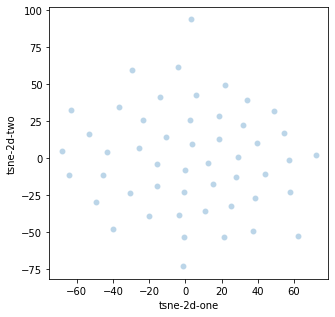

In [20]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

# kMeans

In [64]:
%%time
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import time

features = ['police_dist', 
            'hospital_dist', 
            'bank_dist', 
            'courthouse_dist', 
            'school_dist',
            'university_dist', 
            'marketplace_dist']

train = df[features]
# train = matrix
# X_scaled = MinMaxScaler().fit_transform(train)
X = train

n_clusters = range(2,15)
# list(range(2,21))
results = []

for k in n_clusters:
    start = time.time()
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(X)
    end = time.time()
    duration = end - start
    results.append((k, model.inertia_, duration))

resDF = pd.DataFrame(results, columns=['k', 'distorsion score', 'time']).set_index('k')
resDF.head()

CPU times: user 418 ms, sys: 3.63 ms, total: 421 ms
Wall time: 420 ms


,distorsion score,time
k,,
2,200879.674443,0.013725
3,102164.946735,0.016077
4,68163.301744,0.018609
5,38668.183883,0.021590
6,19285.374474,0.025052


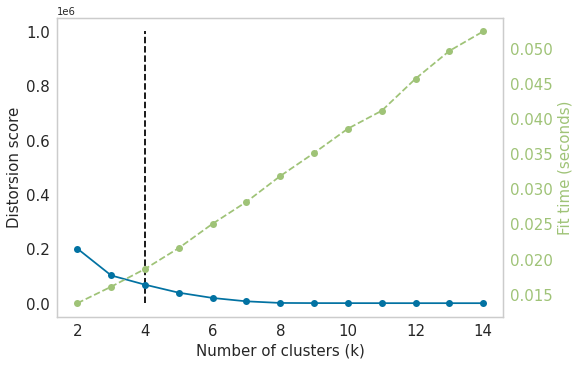

In [67]:
fig, ax = plt.subplots()

ax = resDF.plot(kind='line', y='distorsion score', ax=ax, marker='o')

ax2 = ax.twinx()
resDF.plot(kind='line', y='time', ax=ax2, color='g', marker='o', linestyle='--')
ax.vlines(x=4, ymin=0, ymax=1e6, linestyles='--', color='black')
ax.grid(False)
ax2.grid(False)

ax.tick_params(axis='both', which='major', labelsize='15')
ax2.tick_params(axis='both', which='major', labelsize='15', colors='g')
ax.set_xlabel("Number of clusters (k)", fontsize=15)
ax.set_ylabel("Distorsion score", fontsize=15)
ax2.set_ylabel("Fit time (seconds)", fontsize=15, color='g')

# ax.annotate('elbow at k=6', xy=(6, 1), xytext=(7, 1), fontsize=15, color='red',
#             arrowprops=dict(color='red', width=1.5))

ax.legend().remove()
ax2.legend().remove()

fig.savefig("elbow_curve.png", bbox_inches='tight', dpi=900)

In [59]:
%%time
#k-Means
features = ['police_dist', 
            'hospital_dist', 
            'bank_dist', 
            'courthouse_dist', 
            'school_dist',
            'university_dist', 
            'marketplace_dist']

train = df[features]
# X_scaled = MinMaxScaler().fit_transform(train)
X = train
#k-means
k = 4
kmeansModel = KMeans(n_clusters=k, random_state=0)
kmeansModel.fit(X)

df['kmeans'] = kmeansModel.labels_
df.head()

CPU times: user 19.4 ms, sys: 3.99 ms, total: 23.4 ms
Wall time: 22.3 ms


,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist,tsne-2d-one,tsne-2d-two,kmeans,dbscan,optics
district,,,,,,,,,,,,
ancon,7.704448,99.000000,5.695014,2.781386,6.068907,1.340739,99.000000,43.802593,-10.767971,0,-1,0
ate,2.273455,8.999862,2.411523,1.166379,2.277237,0.545557,6.032080,39.462868,10.205628,1,-1,-1
barranco,0.735640,99.000000,99.000000,1.025315,0.977236,0.493679,1.027768,-14.061898,41.313713,2,0,5
bellavista,1.202801,99.000000,0.893981,0.758440,0.904304,0.602301,1.165141,12.629698,-3.007265,2,1,4
breña,0.732856,99.000000,1.476763,0.574739,0.896399,0.311257,1.430870,71.983345,2.293850,2,1,4


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

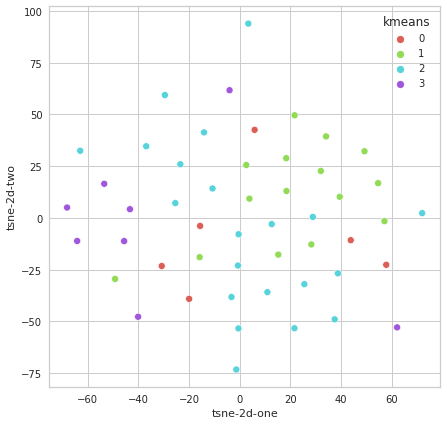

In [60]:
plt.figure(figsize=(7,7))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="kmeans",
    palette=sns.color_palette("hls", k),
    data=df,
    legend="full",
#     alpha=0.3
)

In [40]:
df.reset_index().sort_values('kmeans')

,district,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist,tsne-2d-one,tsne-2d-two,kmeans
2,barranco,0.735640,99.000000,99.000000,1.025315,0.977236,0.493679,1.027768,-14.061898,41.313713,0
17,la_punta,0.470021,99.000000,99.000000,0.470021,0.443151,0.303369,0.766768,37.459576,-49.002972,0
36,san_isidro,0.593385,99.000000,99.000000,3.149071,1.087817,0.547951,1.315586,21.602993,-53.296215,0
39,san_luis,0.905933,99.000000,99.000000,0.716811,0.543059,0.359440,1.422520,-29.512531,59.352566,0
49,villa_maria_del_triunfo,2.617506,5.481353,4.288585,0.838446,1.964174,0.687947,7.817319,28.264610,-12.823297,1
23,lurin,3.677210,5.095849,6.735243,2.515241,3.128620,1.366161,7.530785,34.082020,39.369129,1
20,lince,0.457723,1.218554,1.174418,0.697111,1.286340,0.450168,0.989734,18.355133,28.838039,1
19,lima,0.996302,3.349730,1.515073,0.881661,0.927252,0.425941,1.319367,3.840777,9.296958,1
15,la_molina,1.177299,5.080109,4.377884,2.068178,2.479401,0.674515,1.394166,32.001503,22.677530,1
13,independencia,1.294223,2.302419,2.322738,0.592176,1.112402,0.329430,2.482977,57.112858,-1.563540,1


# DBScan

In [46]:
%%time
from sklearn.cluster import DBSCAN
#k-Means
features = ['police_dist', 
            'hospital_dist', 
            'bank_dist', 
            'courthouse_dist', 
            'school_dist',
            'university_dist', 
            'marketplace_dist']

train = df[features]

X = train

clustering = DBSCAN(eps=3, min_samples=2).fit(X)
print(clustering.labels_)

clustering

df['dbscan'] = clustering.labels_
df.head()

[-1 -1  0  1  1  2 -1  3 -1  1 -1  1  1  2  1  2  3  0  1  2  2  1 -1 -1
  1  4  2 -1  4  1 -1 -1  4  1  5  1  0  2  1  0  6  1  2  5  4  1  2  2
  2  6]
CPU times: user 4.75 ms, sys: 0 ns, total: 4.75 ms
Wall time: 4.24 ms


,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist,tsne-2d-one,tsne-2d-two,kmeans,dbscan
district,,,,,,,,,,,
ancon,7.704448,99.000000,5.695014,2.781386,6.068907,1.340739,99.000000,43.802593,-10.767971,1,-1
ate,2.273455,8.999862,2.411523,1.166379,2.277237,0.545557,6.032080,39.462868,10.205628,2,-1
barranco,0.735640,99.000000,99.000000,1.025315,0.977236,0.493679,1.027768,-14.061898,41.313713,1,0
bellavista,1.202801,99.000000,0.893981,0.758440,0.904304,0.602301,1.165141,12.629698,-3.007265,1,1
breña,0.732856,99.000000,1.476763,0.574739,0.896399,0.311257,1.430870,71.983345,2.293850,1,1


In [48]:
set(clustering.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6}

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

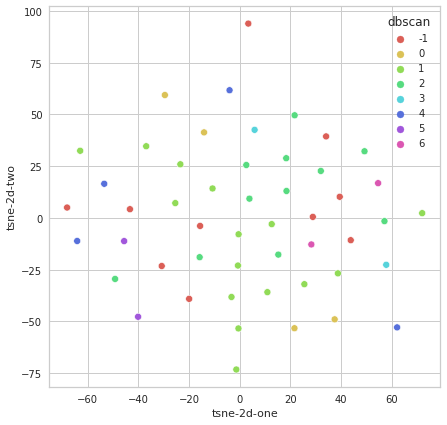

In [49]:
k = len(set(clustering.labels_))

plt.figure(figsize=(7,7))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="dbscan",
    palette=sns.color_palette("hls", k),
    data=df,
    legend="full",
#     alpha=0.3
)

In [50]:
df.reset_index().sort_values('dbscan')

,district,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist,tsne-2d-one,tsne-2d-two,kmeans,dbscan
0,ancon,7.704448,99.000000,5.695014,2.781386,6.068907,1.340739,99.000000,43.802593,-10.767971,1,-1
23,lurin,3.677210,5.095849,6.735243,2.515241,3.128620,1.366161,7.530785,34.082020,39.369129,2,-1
27,pachacamac,6.473313,99.000000,11.449518,2.071445,3.067170,1.248594,13.700207,28.849140,0.485506,1,-1
30,puente_piedra,3.255684,99.000000,3.959908,1.274434,2.038884,0.483277,99.000000,-19.945251,-39.103397,1,-1
31,punta_hermosa,99.000000,99.000000,4.677729,99.000000,4.636647,1.437419,99.000000,-43.290237,4.208823,0,-1
22,lurigancho,7.320638,99.000000,21.046934,2.376797,3.404312,0.952920,4.791883,3.397490,93.872581,1,-1
8,chaclacayo,3.168231,3.349987,3.676956,1.277155,1.657805,0.653061,99.000000,-30.755629,-23.240419,2,-1
10,cieneguilla,99.000000,99.000000,99.000000,4.557271,6.234100,3.802000,99.000000,-68.092094,5.011693,0,-1
6,carabayllo,5.086770,5.297592,7.452323,3.447587,3.441472,0.707013,99.000000,-15.619768,-3.883145,2,-1
1,ate,2.273455,8.999862,2.411523,1.166379,2.277237,0.545557,6.032080,39.462868,10.205628,2,-1


# Optics

In [52]:
%%time
from sklearn.cluster import OPTICS
#k-Means
features = ['police_dist', 
            'hospital_dist', 
            'bank_dist', 
            'courthouse_dist', 
            'school_dist',
            'university_dist', 
            'marketplace_dist']

train = df[features]

X = train

clustering = OPTICS(min_samples=2).fit(X)
print(set(clustering.labels_))

clustering

df['optics'] = clustering.labels_
df.head()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
CPU times: user 39.3 ms, sys: 6 µs, total: 39.4 ms
Wall time: 38.4 ms


,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist,tsne-2d-one,tsne-2d-two,kmeans,dbscan,optics
district,,,,,,,,,,,,
ancon,7.704448,99.000000,5.695014,2.781386,6.068907,1.340739,99.000000,43.802593,-10.767971,1,-1,0
ate,2.273455,8.999862,2.411523,1.166379,2.277237,0.545557,6.032080,39.462868,10.205628,2,-1,-1
barranco,0.735640,99.000000,99.000000,1.025315,0.977236,0.493679,1.027768,-14.061898,41.313713,1,0,5
bellavista,1.202801,99.000000,0.893981,0.758440,0.904304,0.602301,1.165141,12.629698,-3.007265,1,1,4
breña,0.732856,99.000000,1.476763,0.574739,0.896399,0.311257,1.430870,71.983345,2.293850,1,1,4


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

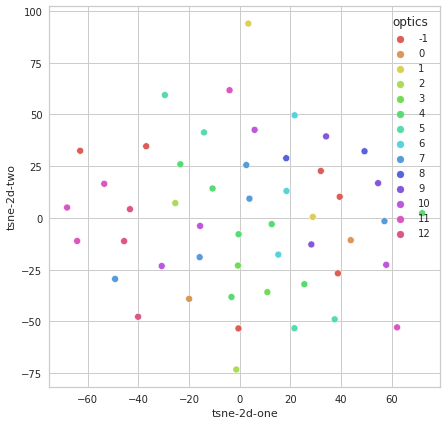

In [53]:
k = len(set(clustering.labels_))

plt.figure(figsize=(7,7))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="optics",
    palette=sns.color_palette("hls", k),
    data=df,
    legend="full",
#     alpha=0.3
)

In [56]:
df.sort_values('optics')

,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist,tsne-2d-one,tsne-2d-two,kmeans,dbscan,optics
district,,,,,,,,,,,,
ate,2.273455,8.999862,2.411523,1.166379,2.277237,0.545557,6.032080,39.462868,10.205628,2,-1,-1
san_borja,0.808257,99.000000,2.657765,2.062091,1.049655,0.574716,1.686152,-0.488178,-53.395668,1,1,-1
rimac,1.355610,99.000000,1.186345,0.545418,0.819652,0.298340,3.841231,38.741535,-26.783901,1,1,-1
la_molina,1.177299,5.080109,4.377884,2.068178,2.479401,0.674515,1.394166,32.001503,22.677530,2,2,-1
comas,1.235112,99.000000,1.941399,0.689423,1.640515,0.313148,3.573966,-62.923100,32.430183,1,1,-1
el_agustino,1.652764,99.000000,1.488830,0.824649,0.753834,0.296183,2.181051,-36.880955,34.617451,1,1,-1
ancon,7.704448,99.000000,5.695014,2.781386,6.068907,1.340739,99.000000,43.802593,-10.767971,1,-1,0
puente_piedra,3.255684,99.000000,3.959908,1.274434,2.038884,0.483277,99.000000,-19.945251,-39.103397,1,-1,0
pachacamac,6.473313,99.000000,11.449518,2.071445,3.067170,1.248594,13.700207,28.849140,0.485506,1,-1,1


# Results 

In [63]:
columns_dist = ['bank_dist', 'courthouse_dist', 'hospital_dist', 'marketplace_dist',
       'police_dist', 'school_dist', 'university_dist', 
               'kmeans']
df.sort_values('kmeans')[columns_dist]

,bank_dist,courthouse_dist,hospital_dist,marketplace_dist,police_dist,school_dist,university_dist,kmeans
district,,,,,,,,
ancon,7.704448,99.000000,5.695014,2.781386,6.068907,1.340739,99.000000,0
carabayllo,5.086770,5.297592,7.452323,3.447587,3.441472,0.707013,99.000000,0
carmen_de_la_legua_reynoso,1.051426,1.046387,1.212121,0.430686,0.639592,0.352251,99.000000,0
chaclacayo,3.168231,3.349987,3.676956,1.277155,1.657805,0.653061,99.000000,0
puente_piedra,3.255684,99.000000,3.959908,1.274434,2.038884,0.483277,99.000000,0
la_perla,0.769345,1.358078,2.218304,0.878485,0.851766,0.455293,99.000000,0
ventanilla,2.140000,6.345118,3.299252,1.306825,2.824698,0.888776,4.357383,1
surquillo,0.919275,2.415734,1.129390,0.616465,0.690635,0.456124,1.975930,1
santa_anita,1.106808,1.163849,1.266832,0.758924,1.795619,0.277775,1.439307,1


In [61]:
df.kmeans.unique()

array([0, 1, 2, 3], dtype=int32)